# 语言模型和数据集
:label:`sec_language_model`

在 :numref:`sec_text_preprocessing` 中，我们了解了如何将文本数据映射到标记中，其中这些标记可以被视为一系列离散的观测，例如单词或字符。假设长度为 $T$ 的文本序列中的标记依次为 $x_1, x_2, \ldots, x_T$。然后，在文本序列中，$x_t$($1 \leq t \leq T$) 可以被认为是时间步 $t$ 处的观测或标签。给定这样的文本序列，*语言模型*（language model）的目标是估计序列的联合概率

$$P(x_1, x_2, \ldots, x_T).$$

语言模型是非常有用的。例如，只需要一次抽取一个标记 $x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$，一个理想的语言模型就能够基于自己生成自然文本。与猴子使用打字机完全不像的是，从这样的模型中出现的所有文本都将作为自然语言来传递，例如英语文本。此外，只需要基于前面的对话片断中的文本，就足以生成一个有意义的对话。显然，离设计这样的系统还很遥远，因为它需要“理解”文本，而不仅仅是生成在语法上合理的内容。

尽管如此，即使在有限的形式下，语言模型也是非常有用的。例如，短语“to recognize speech”和“to wreck a nice beach”听起来非常相似，因为这会导致语音识别中的歧义，然而这很容易通过语言模型来解决，因为第二种翻译感觉怪怪的。同样，在文档摘要生成算法中，“狗咬人”比“人咬狗”出现机会要频繁得多，或者“我想吃奶奶”是一个相当令人不安的语句，而“我想吃，奶奶”要温和得多。

## 学习语言模型

显而易见，我们面对的问题是如何对一个文档，甚至是一串标记进行建模。假设在单词级别对文本数据进行标记化，我们可以求助于在 :numref:`sec_sequence` 中对序列模型的分析。让我们从基本概率规则开始：

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

例如，文本序列包含了四个单词的概率是：

$$P(\text{deep}, \text{learning}, \text{is}, \text{fun}) =  P(\text{deep}) P(\text{learning}  \mid  \text{deep}) P(\text{is}  \mid  \text{deep}, \text{learning}) P(\text{fun}  \mid  \text{deep}, \text{learning}, \text{is}).$$

为了计算语言模型，我们需要计算单词的概率和给定前面几个单词时出现该单词的条件概率。这样的概率本质上就是语言模型的参数。

这里，我们假设训练数据集是一个大型文本语料库，比如，所有维基百科的条目，[古登堡计划](https://en.wikipedia.org/wiki/Project_Gutenberg)，以及发布在网络上的所有文本。训练数据集中词的概率可以根据给定词的相对词频来计算。例如，可以将估计值 $\hat{P}(\text{deep})$ 计算为任何以单词“Deep”开头的句子的概率。一种稍稍不太精确的方法是统计单词“Deep”在数据集中的出现次数，然后将其除以整个语料库中的单词总数。这很有效，特别是对于频繁出现的单词。接下来，我们可以尝试估计

$$\hat{P}(\text{learning} \mid \text{deep}) = \frac{n(\text{deep, learning})}{n(\text{deep})},$$

其中 $n(x)$ 和 $n(x, x')$ 分别是单个单词和连续单词对的出现次数。不幸的是，由于“深度学习”（deep learning）的出现频率要低得多，所以估计单词对的概率要困难得多。特别是，对于一些不常见的单词组合，可能找到足够的出现次数来获得准确的估计将很困难。而对于三个字或者更多字的组合情况会变得更糟。将会存在许多合理的三字组合，但是在数据集中可能找不到。除非我们提供一些解决方案来将这些单词组合指定为非零计数，否则将无法在语言模型中使用它们。如果数据集很小，或者单词非常罕见，我们可能甚至找不到这类单词的一次出现。

一种常见的策略是执行某种形式的 *拉普拉斯平滑*（Laplace smoothing）。解决方案是在所有计数中添加一个小常量。用 $n$ 表示训练集中的单词总数，用 $m$ 表示唯一单词的数量。此解决方案有助于处理单元素问题，例如通过：

$$
\begin{aligned}
    \hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
    \hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
    \hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}
$$

其中，$\epsilon_1,\epsilon_2$ 和 $\epsilon_3$ 是超参数。以 $\epsilon_1$ 为例：当为 $\epsilon_1 = 0$ 时，不应用平滑；当 $\epsilon_1$ 接近正无穷大时，$\hat{P}(x)$ 接近均匀概率 $1/m$。上面的公式是采用其他技术实现了 :cite:`Wood.Gasthaus.Archambeau.ea.2011` 的一个相当原始的变体。

不幸的是，像这样的模型很快就会因为下面的原因变得无效：首先，我们需要存储所有的计数。第二，这完全忽略了单词的意思。例如，“猫”和“猫科动物”应该出现在相关的上下文中。很难将这些模型调整到额外的上下文中，而基于深度学习的语言模型很适合考虑到这一点。最后，长单词序列几乎肯定是新出现的，因此简单地统计先前看到的单词序列频率的模型面对这种问题肯定是表现不佳的。

## 马尔可夫模型与$n$元语法

在讨论基于深度学习的解决方案之前，我们需要更多的术语和概念。回想一下我们在 :numref:`sec_sequence` 中对马尔可夫模型的讨论。让我们将其应用于语言建模。如果 $P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$，则序列上的分布满足一阶马尔可夫性质。阶数越高，对应的依赖关系就越长。这种性质推导出了许多可以应用于序列建模的近似：

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

涉及一个、两个和三个变量的概率公式通常分别称为“一元语法”（unigram）、“二元语法”（bigram）和“三元语法”（trigram）。下面，我们将学习如何设计更好的模型。

## 自然语言统计

让我们看看如何对真实数据起作用。根据 :numref:`sec_text_preprocessing` 中介绍的时光机器数据集构建词汇表，并打印最常用的10个单词。


In [1]:
import random
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

In [2]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行连接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，事实上最流行的词看起来很无聊。它们通常被称为“停用词”（stop words），因此可以被过滤掉。尽管如此，它们仍然有意义，我们仍然会使用它们。此外，显而易见的是词频衰减的速度得相当地快。第 $10$ 个最常用单词的词频还不到最流行单词词频的 $1/5$。为了更好地理解，我们画出了词频图。


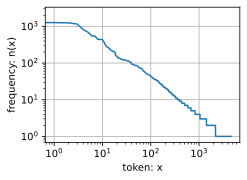

In [3]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log',
         yscale='log')

在这里我们看到了一些非常基本的东西：词频以一种明确的方式迅速衰减。将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。这意味着单词符合 *齐普夫定律*（Zipf's law），即第 $i$ 个最常用单词的频率 $n_i$ 为：

$$n_i \propto \frac{1}{i^\alpha},$$
:eqlabel:`eq_zipf_law`

这相当于

$$\log n_i = -\alpha \log i + c,$$

其中 $\alpha$ 是表征分布的指数，$c$ 是常数。这应该让我们明白想要通过计数统计和平滑来建模单词是不可行的。结果，我们会大大高估尾部单词的频率，也就是所谓的不常用单词。但是其他的单词组合，比如二元语法、三元语法等等，又会如何呢？让我们看看二元语法的频率是否与一元语法的频率表现相同的行为方式。


In [4]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

这里有一件事值得注意。在十个最频繁的词对中，有九个是由两个停用词组成的，只有一个与实际的书——《时间》有关。此外，让我们看看三元频率是否以相同的方式运行。


In [5]:
trigram_tokens = [
    triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

最后，让我们直观地看一下这三种模型中的标记频率：单字、双字和三字。


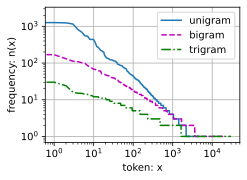

In [6]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

这张图相当令人激动，原因则有很多。首先，除了单字词，单词序列似乎也遵循齐普夫定律，尽管公式 :eqref:`eq_zipf_law` 中的指数 $\alpha$ 更小（指数的大小取决于序列的长度）。其次，词典中 $n$ 元组的数量并没有那么大，说明语言中存在相当多的结构，这给了我们应用模型希望。第三，很多 $n$ 元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。作为代替，我们将使用基于深度学习的模型。

## 读取长序列数据

由于序列数据本质上是连续的，我们需要在处理数据时解决这个问题。我们在 :numref:`sec_sequence` 以一种相当特定的方式做到了这一点。当序列变得太长而不能被模型一次性全部处理时，我们可能希望拆分这样的序列以供阅读。现在让我们描述一下总体策略。在介绍该模型之前，假设我们将使用神经网络来训练语言模型，其中该网络一次处理具有预定义长度的一小批序列，例如 $n$ 个时间步。现在的问题是如何随机读取小批量的特征和标签。

首先，由于文本序列可以是任意长的，例如整个“时光机器”书。我们可以将这样长的序列划分为具有相同时间步数的子序列。当训练我们的神经网络时，这样的小批量子序列将被输入到模型中。假设模型一次只处理具有 $n$ 个时间步的子序列。 :numref:`fig_timemachine_5gram` 画出了从原始文本序列获得子序列的所有不同的方式，其中 $n=5$ 和每个时间步的标记对应于一个字符。请注意，我们有相当大的自由度，因为我们可以选择指示初始位置的任意偏移量。

![分割文本时，不同的偏移量会导致不同的子序列。](../img/timemachine-5gram.svg)
:label:`fig_timemachine_5gram`

因此，我们应该从 :numref:`fig_timemachine_5gram` 中选择哪一个呢？事实上，他们都一样的好。然而，如果我们只选择一个偏移量，那么用于训练网络的所有可能子序列的覆盖范围将是有限的。因此，我们可以从随机偏移量开始划分序列，以同时获得 *覆盖性*（coverage）和 *随机性*（randomness）。下面，我们将描述如何实现 *随机采样*（random sampling）和 *顺序分区*（sequential partitioning）策略。

### 随机采样

在随机采样中，每个样本都是在原始长序列上任意捕获的子序列。在迭代期间，来自两个相邻的、随机的小批量中的子序列不一定在原始序列上相邻。对于语言建模，目标是根据到目前为止我们看到的标记来预测下一个标记，因此标签是移位了一个标记的原始序列。

下面的代码每次都从数据中随机生成一个小批量。这里，参数 `batch_size` 指定了每个小批量中的子序列样本的数目，`num_steps` 是每个子序列中预定义的时间步数。


In [7]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列。"""
    # 从随机偏移量（包括`num_steps - 1`）开始对序列进行分区
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为`num_steps`的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样中，
    # 迭代过程中两个相邻的、随机的小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从`pos`开始的长度为`num_steps`的序列
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 这里，`initial_indices`包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield np.array(X), np.array(Y)

让我们手动生成一个从 $0$ 到 $34$ 的序列。假设批量大小为 $2$ 和时间步数为 $5$。这意味着可以生成 $\lfloor (35 - 1) / 5 \rfloor= 6$ 个“特征－标签”子序列对。设置小批量大小为 $2$ 时，我们只能得到 $3$ 个小批量。


In [8]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  [[ 2.  3.  4.  5.  6.]
 [17. 18. 19. 20. 21.]] 
Y: [[ 3.  4.  5.  6.  7.]
 [18. 19. 20. 21. 22.]]
X:  [[27. 28. 29. 30. 31.]
 [ 7.  8.  9. 10. 11.]] 
Y: [[28. 29. 30. 31. 32.]
 [ 8.  9. 10. 11. 12.]]
X:  [[22. 23. 24. 25. 26.]
 [12. 13. 14. 15. 16.]] 
Y: [[23. 24. 25. 26. 27.]
 [13. 14. 15. 16. 17.]]


### 顺序分区

除了对原始序列进行随机抽样外，我们还可以保证在迭代过程中两个相邻的小批量中的子序列在原始序列上是相邻的。这种策略在基于小批量进行迭代时保留了拆分的子序列的顺序，因此称为顺序分区。


In [9]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列。"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = np.array(corpus[offset:offset + num_tokens])
    Ys = np.array(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

基于相同的设置，让我们把通过顺序分区读取的每个小批量的子序列的特征 `X` 和标签 `Y` 打印出来。请注意，迭代期间来自两个相邻的小批量中的子序列在原始序列中确实是相邻的。


In [10]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  [[ 5.  6.  7.  8.  9.]
 [19. 20. 21. 22. 23.]] 
Y: [[ 6.  7.  8.  9. 10.]
 [20. 21. 22. 23. 24.]]
X:  [[10. 11. 12. 13. 14.]
 [24. 25. 26. 27. 28.]] 
Y: [[11. 12. 13. 14. 15.]
 [25. 26. 27. 28. 29.]]


现在，我们将上述两个采样函数包装到一个类中，以便稍后可以将其用作数据迭代器。


In [11]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器。"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

最后，我们定义了一个函数 `load_data_time_machine` ，它同时返回数据迭代器和词汇表，因此可以与其他带有 `load_data` 前缀的函数（如 :numref:`sec_fashion_mnist` 中定义的 `d2l.load_data_fashion_mnist` ）类似地使用。


In [12]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表。"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

## 小结

* 语言模型是自然语言处理的关键。
* $n$ 元语法，通过截断相关性，为处理长序列提供了一种方便的模型。
* 长序列存在一个问题，那就是它们很少出现或者从不出现。
* 齐普夫定律控制了单词的分布，这个分布不仅适用于单字单词，还适用于其他 $n$ 元语法的单词。
* 通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词组成的词组。
* 读取长序列的主要方式是随机采样和顺序分区。后者可以保证在迭代过程中来自两个相邻的小批量中的子序列在原始序列上也是相邻的。

## 练习

1. 假设训练数据集中有 $100,000$ 个单词。四元语法需要存储多少词频和多词相邻频率？
1. 你将如何将对话建模？
1. 估计“一元语法”（unigram）、“二元语法”（bigram）和“三元语法”（trigram）的齐普夫定律指数。
1. 你还能想到哪些其他的读取长序列数据的方法？
1. 考虑一下我们用于读取长序列的随机偏移量。
    1. 为什么随机偏移量是个好主意？
    1. 它真的会在文档的序列上实现完美的均匀分布吗？
    1. 你要怎么做才能让事情变得更加均衡呢？
1. 如果我们希望一个序列样本是一个完整的句子，那么这在小批量抽样中会带来什么样的问题呢？我们怎样才能解决这个问题呢？


[Discussions](https://discuss.d2l.ai/t/2096)
